In [1]:
#!unzip fashion-mnist.zip

In [1]:
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from PIL import Image
import torch
from torch.autograd import Variable

In [3]:
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [4]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))



N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )


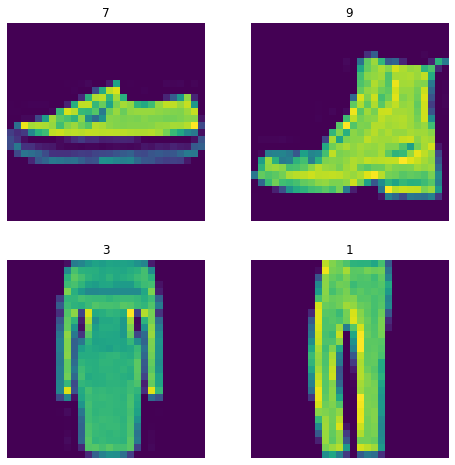

In [5]:
ig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [6]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [34]:
batch_size = 128

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Debe ser diferente a la utilizada en clase.

Tener al menos dos capas convolucionales.

Tener capas de Max o Global Average Pooling.

## Modelo

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
#--- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
  # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*8

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 = 14                 -> 14*14*16

  torch.nn.Dropout(p=0.4),

  torch.nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
  # ( (14-5+2*2)/1 ) + 1 = 14   -> 14*14*16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 14/2 = 7                 -> 7*7*16
  
  torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
  # ( (7-5+2*2)/1 ) + 1 = 7   -> 7*7*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 7/2 = 3.5=3                -> 3*3*32

  torch.nn.Dropout(p=0.4), 

  torch.nn.Flatten(),
  torch.nn.Linear(3*3*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.4, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Dropout(p=0.4, inplace=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=288, out_features=10, bias=True)
)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


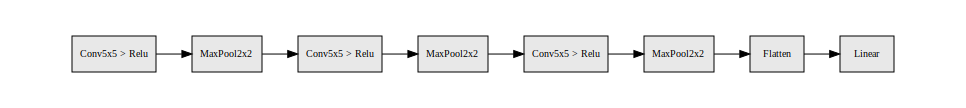

In [36]:
import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

Como se puede observar en el gráfico el modelo contine 3 capas convolucionales, lo que significa en 8 capas totales, la capas tiene las caracteristicas de 28 14 7 (esto porque cada kernel de pool es 2) 
***

In [37]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)
len(train_dl)

430

In [38]:
from sklearn.metrics import f1_score

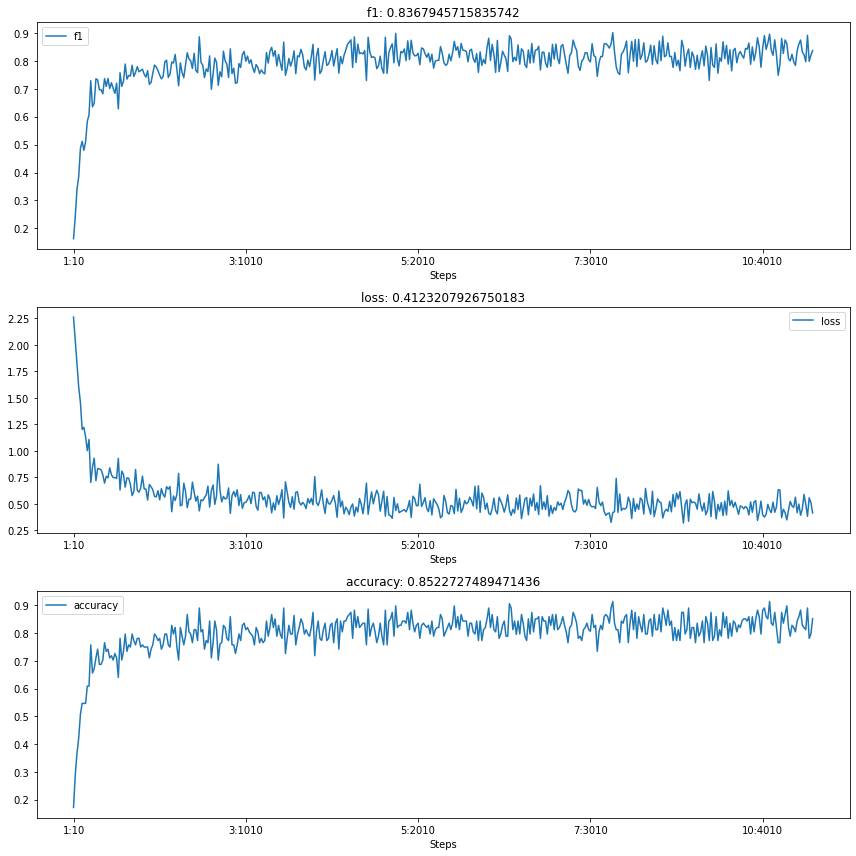

In [39]:
n_epoch = 10

history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history2.log((epoch+1, iter),f1=f1, loss=loss, accuracy=acc)
        with canvas2:
          canvas2.draw_plot(history2["f1"])
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])

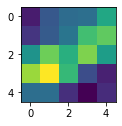

In [26]:
kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels[0].size(0)):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[i].squeeze())
    k += 1
plt.show()

Recuperando la amtriz de confunción de las actividades pasadas 

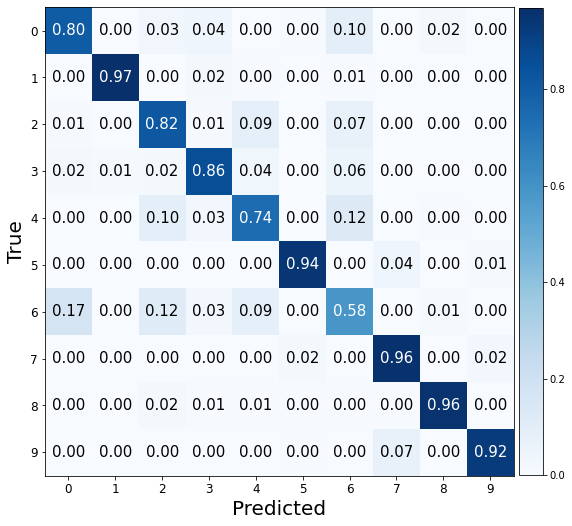

In [41]:
from sklearn.metrics import confusion_matrix
def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

CM(Y_valid.cpu(), Y_pred.cpu(), 10)

Considerando que la clasficiación de los objetos es
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

Se puede ver en el gráfico como *Trouser* (1) es la que el modelo reconoce mejor mientras que *Shirt* (6) es la peor. El modelo tiende a confundir esta ultima con  *T-shirt/top*(0) y *Pullover*(2).

In [63]:
import pandas as pd 

score = pd.DataFrame({'score':['f1','loss','accuracy'],'values':[f1,loss.item(),acc.item()]})

Los scores de modelo fuero:

In [64]:
score

,score,values
0,f1,0.855892
1,loss,0.422620
2,accuracy,0.856300


In [44]:
print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.42, F1:0.86, Acc:0.86


Por lo que se puede considerar como un regular, es decir acierta predice correctamente en la mayoria de los casos pero es posible mejoraralo.

*Todo el notebook esta basado en la notebooks prensentados en la clase: 
https://github.com/ComputoCienciasUniandes/IntroDeepLearning_202102/blob/main/notebooks/13_Clasificaci%C3%B3n_con_CNN.ipynb